## Question-2

- Here we need to indetify the different key words from job descripotion that can distinguish differnt job category.
- For this we are using job descrption and pre process the text by tokenizing and lemmatizing it.
- Than used TdIdf to convert text data to be able to work with different model
- Truncated SVD is used to reduce the dimensionality of this text data to genralise model result and prevent overfitting
- For this problem we are indetifying the key words in categories like data analyst, data scientist, data engineer, business analyst and business intelligence

In [2035]:
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords


from sklearn.metrics import silhouette_score,confusion_matrix,classification_report,precision_recall_fscore_support

from sklearn.utils import resample

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier
from xgboost import XGBClassifier

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd



from sklearn.decomposition import PCA,TruncatedSVD

from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

#### Import data file

In [1966]:
data_file = './data/cleaned_job_data'

In [1967]:
df_job_data = pd.read_csv(data_file)

In [1968]:
df_job_data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [1969]:
df_job_data.shape

(1856, 5)

In [1970]:
df_job_data['job_title'].isnull().sum()

0

In [1971]:
#define a function to generate different class from job title
def clean_job_titles(title):
    if 'business analyst '  in title or 'business analyst' in title or 'ba' in title:
        return 'Business Analyst'
    if 'data analyst' in title:
        return 'Data Analyst'
    if 'data engineer' in title:
        return 'Data Engineer'
    if 'business intelligence' in title or 'bi' in title:
        return 'Business Intellegence'
    if 'data scientist' in title or 'machine learning' in title:
        return 'Data Scientist'
    else:
        return title

In [1972]:
df_job_data['job_title'] = df_job_data['job_title'].apply(lambda x:clean_job_titles(x.lower()))

In [1973]:
#drop all the other job titles
df_job_data.drop(df_job_data[(df_job_data['job_title']!='Business Analyst') & (df_job_data['job_title']!='Business Intellegence') \
            & (df_job_data['job_title']!='Data Analyst') & (df_job_data['job_title']!='Data Engineer') \
           & (df_job_data['job_title']!='Data Scientist')].index,inplace=True)

In [1974]:
df_job_data.shape

(1122, 5)

In [1975]:
#dropping values having job desc as null
df_job_data.drop(df_job_data[df_job_data['job_desc'].isnull()].index,inplace=True)
df_job_data.shape

(1116, 5)

In [1976]:
#dropping all data that have 'None' as job description
df_job_data.drop(df_job_data['job_desc'][df_job_data['job_desc']=='None'].index,inplace=True)
df_job_data.shape

(976, 5)

In [1977]:
#baseline
df_job_data['job_title'].value_counts(normalize=True)

Business Analyst         0.691598
Data Analyst             0.131148
Business Intellegence    0.094262
Data Engineer            0.048156
Data Scientist           0.034836
Name: job_title, dtype: float64

In [1978]:
#define text pre processing function
def lemmatize_data(job_desc):
    lemmatizer = WordNetLemmatizer()
    job_desc = re.sub(r'[0-9]', '', job_desc, flags=re.I)
    lem_verb = ' '.join([lemmatizer.lemmatize(each_word, pos='v') for each_word in word_tokenize(job_desc)])
    #lem_noun = ' '.join([lemmatizer.lemmatize(each_word, pos='n') for each_word in word_tokenize(lem_verb)])
    return lem_verb

In [1979]:
X = df_job_data['job_desc'].apply(lambda x:lemmatize_data(x))

In [1980]:
#define your own custom words
custom_stop_words = ['immidiate', 'job','senior','junior','experience','contract','permanent','full-time','work', \
                    'officer','manager','capgemini','geelong','men','newcastle','business analyst','level','please','button',
                     'call','recruitment', 'international','need', 'follow','type' ,'fulltimesalary','company', 'base',\
                     'end', 'development','detail', 'understand','whats', 'next','opportunity', 'rolethe','level',\
                     'please','skills', 'responsibilitieswhat','cbd','opportunity','minimum','month','understandingattention',\
                     'detailwork','bonus' ,'great','terry', 'chandramun','cv', 'call','applicants','encourage','act',\
                     'australia','fourquarters', 'com','send', 'update','join','shortlist','contact','change','within',\
                     'first', 'instance','www', 'au','add','advantage','location', 'melbourne','environment', 'excellent',\
                     'digital', 'service','new','ensure','accurate','lead', 'organisation','ability', 'quickly',\
                     'team', 'well','position', 'us','suit','look', 'confidential','discussion', 'career','would','ideal',\
                     'previouslyworking', 'managementhead', 'ofexecutive', 'note', 'role', 'squad', 'youto', 'squad', 'anzat',\
                     'culture', 'companyour', 'responsiblefor', 'passion', 'good', 'maintenancebasic', 'professional', 'drive',\
                     'suburbs', 'learn', 'ideas', 'continuous', 'consdier', 'consdier', 'due', 'continuous','growth',\
                     'communication','australian', 'innovative', 'anz', 'southeast','adelaide', 'successful', 'consider',\
                     'global', 'regard', 'citizens', 'chapter', 'clean', 'conduit', 'property', 'dan', 'closely', 'immediately',\
                     'wire', 'handle', 'also', 'successful', 'eventually', 'turn', 'candidate','smart', 'publish', 'disability',\
                     'managementleadership', 'personal', 'promote', 'underperformance', 'create', 'proactively', 'topic',\
                     'expertise','improve','datadriven','receive','data','set','standards','hill','prominent','woolworths',\
                     'highly','group','headquarters','wa','liebhheraustralia','client','medical','center','seer','already',\
                     'technologyabout', 'youbechlors']

In [1981]:
#add those words to stop_words list
stopwords = stopwords.words('english')
stopwords.extend(custom_stop_words)

In [1982]:
#define a function to generate TfIdf vector
def create_tfidf_vec(data):
    tfidf = TfidfVectorizer(stop_words=stopwords,max_df=8,min_df=2,sublinear_tf=True,ngram_range=(2,2))
    tfidf.fit(data)
    X_vec = pd.DataFrame(tfidf.transform(data).todense(), columns=tfidf.get_feature_names())
    feature_names = tfidf.get_feature_names()
    return X_vec,feature_names

In [1983]:
X_vec,feature_names = create_tfidf_vec(X)

In [1984]:
X_vec.shape

(976, 21892)

In [1985]:
#use this information to create your own custom words list. remove all the words that are not giving much information by adding them
#to stop words
#This are the top wordsin each document
word_counts = X_vec.sum(axis=0)
word_counts.sort_values(ascending = False).head(100)

database developer         1.811572
devops engineer            1.423505
oracle dba                 1.368109
bank amp                   1.338210
analyst legacy             1.337659
project health             1.337659
legacy project             1.337659
document system            1.337236
financial sector           1.295550
document management        1.265532
industry leader            1.231922
insurance industry         1.221603
mysql oracle               1.221008
requirements apply         1.215713
baseline security          1.206606
finance systems            1.190331
matter expert              1.181923
management support         1.177025
credit risk                1.169499
governance framework       1.161003
build capability           1.159795
software project           1.154036
right reference            1.148904
health industry            1.144957
machine engineer           1.144810
database analyst           1.144771
machine algorithms         1.144640
requirements strong        1

In [1986]:
#define function for test train split
def create_test_train_split(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=43,test_size=0.33,shuffle=True)
    return X_train,X_test,y_train,y_test

In [1987]:
#define a funciton to generate different model results and return test and train score and also cross validated test train score
def generate_model_result(model_obj,X,y):
    X_train,X_test,y_train,y_test = create_test_train_split(X,y)
#    print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
    model = model_obj.fit(X_train,y_train)
    training_score = model.score(X_train,y_train)
    testing_score = model.score(X_test,y_test)
    cv_train_score = np.mean(cross_val_score(model,X_train,y_train,cv=5,n_jobs=3))
    cv_test_score = np.mean(cross_val_score(model,X_test,y_test,cv=5,n_jobs=3))
    y_pred = model.predict(X_test)
    return training_score,testing_score,cv_train_score,cv_test_score,y_pred,y_test

In [1988]:
# Logistic regression  model on job desc
lr = LogisticRegression(penalty='l2',C=0.5 , random_state=47, n_jobs=3)


In [1989]:
#call generate_model_result function
training_score , testing_score ,cv_train_score,cv_test_score,y_pred,y_test = generate_model_result(lr,X_vec,df_job_data['job_title'])

In [1990]:
#model result
training_score, testing_score,cv_train_score,cv_test_score

(0.6860643185298622,
 0.7027863777089783,
 0.6860803697160878,
 0.7034109847783414)

In [1991]:
#define function to generate classification report
def genrate_classificatoin_report(y_test,y_pred):
    print(classification_report(y_test,y_pred))

In [1992]:
genrate_classificatoin_report(y_test,y_pred)

                       precision    recall  f1-score   support

     Business Analyst       0.70      1.00      0.83       227
Business Intellegence       0.00      0.00      0.00        33
         Data Analyst       0.00      0.00      0.00        38
        Data Engineer       0.00      0.00      0.00        12
       Data Scientist       0.00      0.00      0.00        13

            micro avg       0.70      0.70      0.70       323
            macro avg       0.14      0.20      0.17       323
         weighted avg       0.49      0.70      0.58       323



In [1993]:
#define function to generate confusion matrix
def generate_confusion_matrix(y_test,y_pred):
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots()


# Create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix,columns=['Business Analyst','Business Intellegence','Data Analyst','Data Engineer','Data Scientist'],\
                             index=['Business Analyst','Business Intellegence','Data Analyst','Data Engineer','Data Scientist']),\
                annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

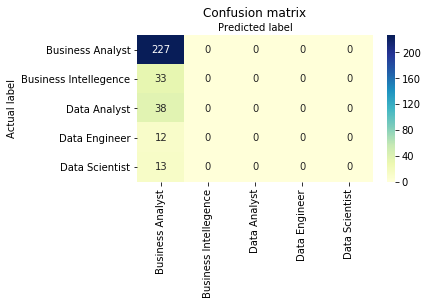

In [1994]:
generate_confusion_matrix(y_test,y_pred)

### Class Imbalance

- Above we can see that we have class imbalance and because of that our model is not performing good.
- To remove this class imbalance and to improve the performance we can resample the class that has lowe counts

In [1995]:
def upsample_class(df_job_data):
    df_data_analyst = df_job_data[df_job_data['job_title']=='Data Analyst']
    df_business_analyst = df_job_data[df_job_data['job_title']=='Business Analyst']
    df_business_intellegence = df_job_data[df_job_data['job_title']=='Business Intellegence']
    df_data_engineer = df_job_data[df_job_data['job_title']=='Data Engineer']
    df_data_scientist = df_job_data[df_job_data['job_title']=='Data Scientist']
    
    # Upsample minority class
    df_data_analyst_upsampled = resample(df_data_analyst, 
                                     replace=True,     # sample with replacement
                                     n_samples=452,    # to match majority class
                                     random_state=123) # reproducible results

    df_business_intellegence_upsampled = resample(df_business_intellegence, 
                                     replace=True,     # sample with replacement
                                     n_samples=529,    # to match majority class
                                     random_state=123) # reproducible results

    df_data_engineer_upsampled = resample(df_data_engineer, 
                                     replace=True,     # sample with replacement
                                     n_samples=480,    # to match majority class
                                     random_state=123) # reproducible results

    df_data_scientist_upsampled = resample(df_data_scientist, 
                                     replace=True,     # sample with replacement
                                     n_samples=559,    # to match majority class
                                     random_state=123) # reproducible results
    
    df_upsampled = pd.concat([df_business_analyst,df_business_intellegence_upsampled,df_data_analyst_upsampled,\
                         df_data_engineer_upsampled,df_data_scientist_upsampled])
 
    return df_upsampled

In [1996]:
df_job_data.shape

(976, 5)

In [1997]:
df_upsampled = upsample_class(df_job_data)

In [1998]:
df_upsampled.shape

(2695, 5)

In [1999]:
#text preprocessing of upsample data frame
X = df_upsampled['job_desc'].apply(lambda x:lemmatize_data(x))

In [2000]:
#Tfidf vector for upsample data
X_vec,feature_names = create_tfidf_vec(X)

In [2001]:
X_vec.shape

(2695, 29281)

In [2002]:
#define reducedimension function to reduce dimensinality in data
def reduce_dimensions(X):
    svd = TruncatedSVD(n_components=400)
    svd = svd.fit(X)
    print(svd.explained_variance_ratio_.sum())
    X_reduce_vec = svd.transform(X)
    
    return X_reduce_vec,svd

In [2003]:
# only 400 components out of 29349 components is able to explain 81% variance in data
X_reduce_vec,svd = reduce_dimensions(X_vec)

0.8129040798460436


In [2004]:
X_reduce_vec.shape

(2695, 400)

In [2005]:
X_vec.shape

(2695, 29281)

In [2006]:
df_upsampled['job_title'].shape

(2695,)

#### Logistic regression to indetify top keywords

In [2007]:
#lr = LogisticRegression(penalty='l1',C=1700, random_state=47, n_jobs=3)
#lr = LogisticRegression(penalty='l2',C=1700, random_state=47, n_jobs=3)a

lr = LogisticRegression(penalty='l1',C=1700, random_state=47, n_jobs=3)


In [2008]:
training_score , testing_score ,cv_train_score,cv_test_score,y_pred,y_test = generate_model_result(lr,X_reduce_vec,df_upsampled['job_title'])

In [2009]:
#model result
training_score , testing_score ,cv_train_score,cv_test_score

(0.8022160664819945,
 0.7820224719101123,
 0.7684258963314714,
 0.7167471510662459)

In [2010]:
genrate_classificatoin_report(y_test,y_pred)

                       precision    recall  f1-score   support

     Business Analyst       0.97      0.98      0.97       199
Business Intellegence       0.96      0.73      0.83       192
         Data Analyst       0.96      0.90      0.93       145
        Data Engineer       1.00      0.25      0.40       165
       Data Scientist       0.52      1.00      0.68       189

            micro avg       0.78      0.78      0.78       890
            macro avg       0.88      0.77      0.76       890
         weighted avg       0.87      0.78      0.77       890



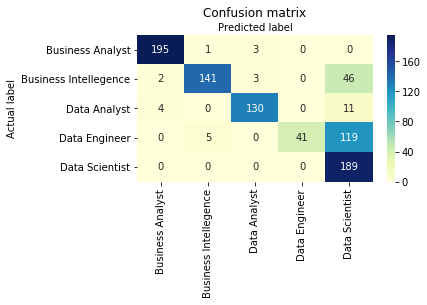

In [2011]:
generate_confusion_matrix(y_test,y_pred)

#### Randomforest classifier to predict keywords in different category

In [2012]:

# forest_clf=RandomForestClassifier(n_estimators=30,max_depth=12,random_state=43,criterion='entropy', \
#                                  max_features=20)
forest_clf=RandomForestClassifier(n_estimators=50,max_depth=17,random_state=43,criterion='entropy', \
                                 max_features=30)

In [2013]:
X_reduce_vec.shape

(2695, 400)

In [2014]:
training_score , testing_score ,cv_train_score,cv_test_score,y_pred,y_test = generate_model_result(forest_clf,X_reduce_vec,df_upsampled['job_title'])

In [2015]:
#model result
training_score , testing_score ,cv_train_score,cv_test_score

(0.8022160664819945,
 0.7820224719101123,
 0.7795032951311203,
 0.7470857276550579)

In [2017]:
genrate_classificatoin_report(y_test,y_pred)

                       precision    recall  f1-score   support

     Business Analyst       0.94      0.98      0.96       199
Business Intellegence       1.00      0.73      0.85       192
         Data Analyst       0.94      0.89      0.91       145
        Data Engineer       1.00      0.25      0.40       165
       Data Scientist       0.52      1.00      0.68       189

            micro avg       0.78      0.78      0.78       890
            macro avg       0.88      0.77      0.76       890
         weighted avg       0.88      0.78      0.77       890



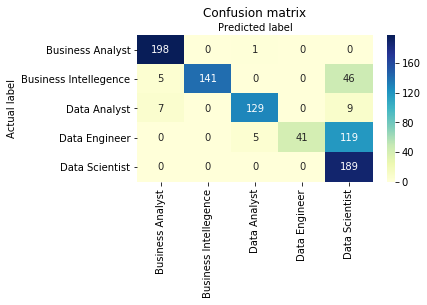

In [1958]:
generate_confusion_matrix(y_test,y_pred)

In [1704]:
word_counts = X_vec.sum(axis=0)
word_counts.sort_values(ascending = False).head(100)

sydney finance                     8.000000
platform engineer                  4.604967
metrics toolkit                    4.041452
bring everything                   4.041452
system knowledge                   4.041452
engineer insights                  2.719768
party leader                       2.719768
architect big                      2.693772
azure architect                    2.693772
locate database                    2.645751
database successfulin              2.645751
mysql aws                          2.645751
aws apply                          2.645751
developer provide                  2.645751
foundation sql                     2.645751
strong foundation                  2.645751
factory databricks                 2.172679
syntax ideally                     2.093810
amp rat                            2.093810
system responsibilities            2.093810
target amp                         2.093810
request prove                      2.093810
ideally informix                

In [1959]:
genrate_classificatoin_report(y_test,y_pred)

                       precision    recall  f1-score   support

     Business Analyst       0.94      0.99      0.97       199
Business Intellegence       1.00      0.73      0.85       192
         Data Analyst       0.96      0.89      0.92       145
        Data Engineer       1.00      0.25      0.40       165
       Data Scientist       0.52      1.00      0.68       189

            micro avg       0.78      0.78      0.78       890
            macro avg       0.88      0.77      0.76       890
         weighted avg       0.88      0.78      0.77       890



In [2040]:
#xgb_model = XGBClassifier(max_depth=10,learning_rate=0.1,n_estimators=10,n_jobs=3)


In [ ]:
#training_score , testing_score ,cv_train_score,cv_test_score,y_pred,y_test = generate_model_result(xgb_model,X_vec,df_upsampled['job_title'])

In [ ]:
#training_score , testing_score ,cv_train_score,cv_test_score

In [1960]:
## running lr again to take to coeefs to plot top words in each class
lr = LogisticRegression(penalty='l1',C=1100, random_state=47, n_jobs=3)


In [1961]:
training_score , testing_score ,cv_train_score,cv_test_score,y_pred,y_test = generate_model_result(lr,X_vec,df_upsampled['job_title'])

In [1962]:
lr_coef_counts = pd.DataFrame(lr.coef_, columns=X_vec.columns, index=['BA','BI', 'DA', 'DE', 'DS']).T

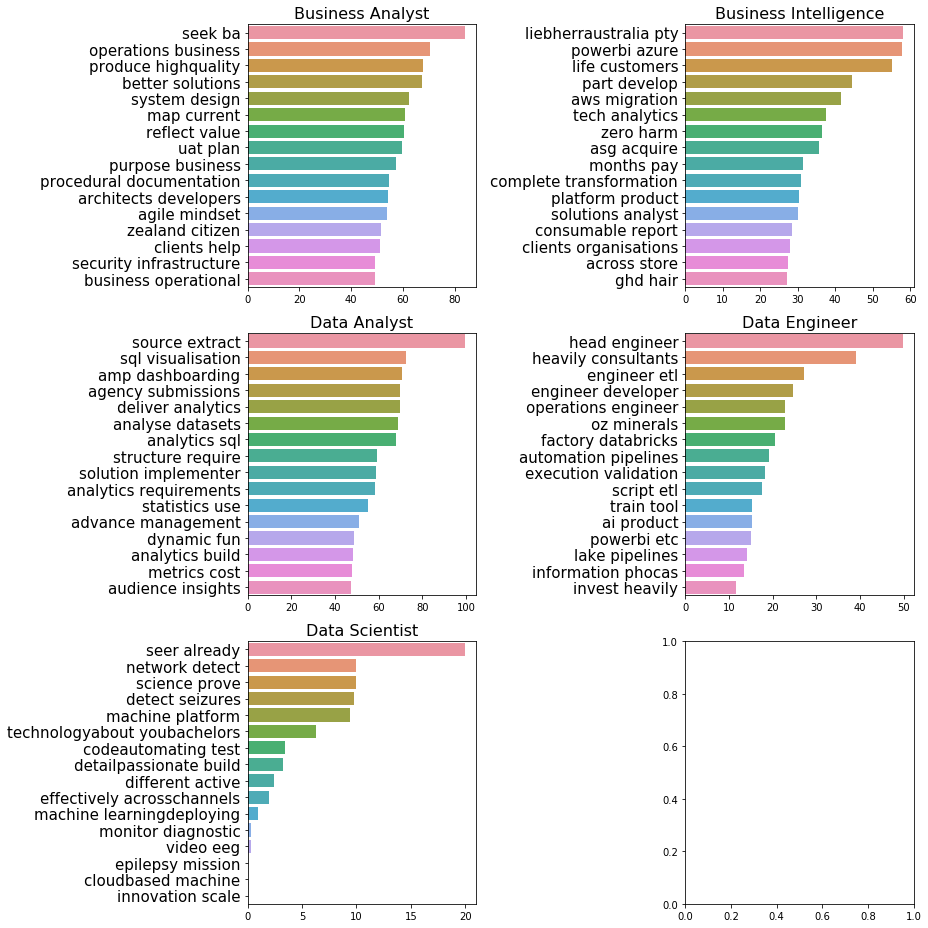

In [1963]:
fig, ax = plt.subplots(3,2, figsize=(13,13))

titles = ['Business Analyst', 'Business Intelligence','Data Analyst', 'Data Engineer', 'Data Scientist']



for i, ax in enumerate(ax.flat):
    plt.sca(ax)
    if i<=4:
        col = lr_coef_counts.columns[i]
        y = lr_coef_counts[col].sort_values(ascending=False).head(16).index
        x = lr_coef_counts[col].sort_values(ascending=False).head(16)
        sns.barplot(x=x, y=y, ax=ax)
        ax.set_yticklabels(y, fontsize=15)
        plt.title(titles[i], fontsize=16)
        plt.xlabel('')
plt.subplots_adjust(wspace=0.7,hspace=0.7)
fig.tight_layout()
plt.show()

In [1755]:
best_fearures = [feature_names[i] for i in svd.components_[5].argsort()[::-1]]


In [1756]:
best_fearures

['factory databricks',
 'sqlssrsss dashboard',
 'track selfstarter',
 'focus report',
 'apply chat',
 'require ssrssql',
 'build track',
 'initially focus',
 'scale require',
 'selfstarter sqlssrsss',
 'developer enterprise',
 'ssrssql tableau',
 'powerbi integral',
 'report bas',
 'bas bi',
 'powerbi apply',
 'validation monitor',
 'execution validation',
 'monitor improvement',
 'implementation execution',
 'developer extensions',
 'thorough comprehensive',
 'sense large',
 'biographic target',
 'sql verbal',
 'engineer bachelor',
 'engineer azure',
 'industry infrastructure',
 'documentation critical',
 'research industry',
 'provide intelligence',
 'domains include',
 'move big',
 'support network',
 'support efforts',
 'take complex',
 'regional domains',
 'efforts support',
 'efforts move',
 'vulnerability must',
 'handson sql',
 'analytic customers',
 'target vulnerability',
 'equivalent spark',
 'databricks requirements',
 'databricks strong',
 'year handson',
 'scala thorough'